## ANALYZE
the data

This is a work in progress  

Vectorize the data in beer.review  
Diminish the importance of common words  
Compare ML algorithms to use the review data to predict beer.style  

Compare ML algorithms to predict beer.rating

In [290]:
# IMPORT MODULES AND THE DATA SET
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('beer.csv', header=0)
df_copy = df  #save a copy of dataframe for reference. 
print('length',len(df))
pd.set_option('max_colwidth', 220)
df.head(3)

length 80818


,name,brewery,style,rating,review
0,Big Rock Ale,Big Rock Brewery,Scottish Ale,3.90,"smell  soft hop aroma with significant malt scents. this one smells very creamy. taste  and creamy it is. the traditional irish flavors come out at the tongue. this is creamy, not like a cream ale, but close. the m..."
1,Flip Ale,Dogfish Head Craft Brewery,Old Ale,4.08,on tap at dfh rehoboth... collab with eatily... cardamom and red wine must. golden orange. .no head. typical dfh yeast aroma. ..some spice and maybe a belgian influence. sweet spicy and somewhat fruity.. not much ol...
2,The Almond Marzen Project - Beer Camp #26,Sierra Nevada Brewing Co.,Märzen / Oktoberfest,3.78,"nice auburn impressions, tons of clarity, solid inch of off white head. aroma was a little bit sweet and nutty. taste gave a little more sweetness, stayed away from hops and bitterness, relatively light bodied. no..."


In [291]:
df['review'][7]

' '

In [292]:
# DATA PREP
print('df original length',len(df))
# drop all reviews with < 20 characters
df = df[df['review'].map(len) > 20]
print('length without short reviews',len(df))

# reset dataframe index for the shortened dataframe
df['index'] = np.arange(len(df))
df = df.set_index('index')

# Change review to a string of words.  remove non-letters, make lower case, split into words.  
# Remove stopwords (common words.)  Join back together into a long string of words. 
def review_to_words(review):
    letters_only = re.sub('[^a-zA-Z]',' ', review)
    words = letters_only.lower().split()
    stops = set(stopwords.words('english'))  
    good_words = [w for w in words if not w in stops]
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in good_words]
    return(' '.join(good_words))

# clean the reviews
df['clean_review'] = df['review'].apply(review_to_words)

df.head(3)

df original length 80818
length without short reviews 49141


/Users/brentmarijensen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,name,brewery,style,rating,review,clean_review
index,,,,,,
0,Big Rock Ale,Big Rock Brewery,Scottish Ale,3.90,"smell  soft hop aroma with significant malt scents. this one smells very creamy. taste  and creamy it is. the traditional irish flavors come out at the tongue. this is creamy, not like a cream ale, but close. the m...",smell soft hop aroma significant malt scents one smells creamy taste creamy traditional irish flavors come tongue creamy like cream ale close malt big buttery smooth hops unique sharp hop flavor easy saturated well m...
1,Flip Ale,Dogfish Head Craft Brewery,Old Ale,4.08,on tap at dfh rehoboth... collab with eatily... cardamom and red wine must. golden orange. .no head. typical dfh yeast aroma. ..some spice and maybe a belgian influence. sweet spicy and somewhat fruity.. not much ol...,tap dfh rehoboth collab eatily cardamom red wine must golden orange head typical dfh yeast aroma spice maybe belgian influence sweet spicy somewhat fruity much old ale characteristic light still tasty cardamom add ni...
2,The Almond Marzen Project - Beer Camp #26,Sierra Nevada Brewing Co.,Märzen / Oktoberfest,3.78,"nice auburn impressions, tons of clarity, solid inch of off white head. aroma was a little bit sweet and nutty. taste gave a little more sweetness, stayed away from hops and bitterness, relatively light bodied. no...",nice auburn impressions tons clarity solid inch white head aroma little bit sweet nutty taste gave little sweetness stayed away hops bitterness relatively light bodied nothing almond came obvious kind fancied oktober...


In [293]:
df.name.size

49141

In [294]:
# ADDITIONAL FEATURE ENGINEERING
# review length
df['review_length'] = df['review'].apply(len)

# average word length
def avg_word_len(words):
    separate_words = words.split()
    count_words = (len(separate_words))    # number of words
    if count_words> 0:
        characters = len(words)  # length of text
        avg = (characters - count_words+1)/count_words
    else:
        avg = 5.65  # this is the mean of 49000 reviews    
    return avg   

df['avg_word_length'] = df['clean_review'].apply(avg_word_len)

In [295]:
print('mean:',df['review_length'].mean())
print('max: ',df['review_length'].max())
print('min: ',df['review_length'].min())
print('')
print('mean:',df['avg_word_length'].mean())
print('max: ',df['avg_word_length'].max())
print('min: ',df['avg_word_length'].min())

mean: 1928.5620764738203
max:  22085
min:  21

mean: 5.684227299077345
max:  11.0
min:  3.0


In [296]:
styles = df.groupby(['style']).size() 
print('Number of styles used:', len(styles))
print('')
print(styles.index)

Number of styles used: 104

Index(['Altbier', 'American Adjunct Lager', 'American Amber / Red Ale',
       'American Amber / Red Lager', 'American Barleywine',
       'American Black Ale', 'American Blonde Ale', 'American Brown Ale',
       'American Dark Wheat Ale', 'American Double / Imperial IPA',
       ...
       'Scotch Ale / Wee Heavy', 'Scottish Ale',
       'Scottish Gruit / Ancient Herbed Ale', 'Smoked Beer', 'Tripel',
       'Vienna Lager', 'Weizenbock', 'Wheatwine', 'Winter Warmer', 'Witbier'],
      dtype='object', name='style', length=104)


In [297]:
# COMBINE SIMILAR STYLES OF BEER.  

df['style'].replace('Saison / Farmhouse Ale', 'Farm Ale', inplace=True)
df['style'].replace('Bière de Garde', 'Farm Ale', inplace=True)
df['style'].replace('American IPA', 'IPA', inplace=True)
df['style'].replace('English India Pale Ale (IPA)', 'IPA', inplace=True)
df['style'].replace('Belgian IPA', 'IPA', inplace=True)
df['style'].replace('Scotch Ale / Wee Heavy', 'Scottish Ale', inplace=True)
df['style'].replace('American Pale Ale (APA)', 'Pale Ale', inplace=True)
df['style'].replace('English Pale Ale', 'Pale Ale', inplace=True)
df['style'].replace('Belgian Pale Ale', 'Pale Ale', inplace=True)
df['style'].replace('American Brown Ale', 'Brown Ale', inplace=True)
df['style'].replace('English Brown Ale', 'Brown Ale', inplace=True)
df['style'].replace('English Dark Mild Ale', 'Brown Ale', inplace=True)
df['style'].replace('American Stout', 'Stout', inplace=True)
df['style'].replace('English Stout', 'Stout', inplace=True)
df['style'].replace('Milk / Sweet Stout', 'Stout', inplace=True)
df['style'].replace('Oatmeal Stout', 'Stout', inplace=True)
df['style'].replace('Oatmeal Stout', 'Stout', inplace=True)
df['style'].replace('American Double / Imperial Stout', 'Imperial Stout', inplace=True)
df['style'].replace('Russian Imperial', 'Imperial Stout', inplace=True)
df['style'].replace('American Porter', 'Porter', inplace=True)
df['style'].replace('Baltic Porter', 'Porter', inplace=True)
df['style'].replace('English Porter', 'Porter', inplace=True)
df['style'].replace('American Amber / Red Lager', 'Lager', inplace=True)
df['style'].replace('Vienna Lager', 'Lager', inplace=True)
df['style'].replace('German Pilsener', 'Lager', inplace=True)
df['style'].replace('Munich Helles Lager', 'Lager', inplace=True)
df['style'].replace('American Adjunct Lager', 'American Lager', inplace=True)
df['style'].replace('American Pale Lager', 'American Lager', inplace=True)
df['style'].replace('American Barleywine', 'Barleywine', inplace=True)
df['style'].replace('English Barleywine', 'Barleywine', inplace=True)
df['style'].replace('English Bitter', 'Bitter', inplace=True)
df['style'].replace('Extra Special / Strong Bitter (ESB)', 'Bitter', inplace=True)
df['style'].replace('American Pale Wheat Ale', 'Wheat', inplace=True)
df['style'].replace('Witbier', 'Wheat', inplace=True)
#df['style'].replace('Witbier', 'Wheat', inplace=True)


# remove uncommon styles (in EDA, I found 13 styles with fewer than 60 reviews)
#uncommon = [ 'American Dark Wheat Ale','Bière de Champagne / Bière Brut', 'Black & Tan', 
#            'Eisbock', 'Faro', 'Gueuze', 'Happoshu', 'Japanese Rice Lager', 'Kristalweizen',
#            'Kvass', 'Lambic - Unblended','Roggenbier', 'Sahti' ]   
labels = df.groupby(['style']).size() 
uncommon = labels[labels<160]
df = df.loc[~df['style'].isin(uncommon.index)]
print('length without uncommon styles',len(df))

length without uncommon styles 46861


In [298]:
print(len(uncommon), 'styles excluded:')
print(uncommon.index)

30 styles excluded:
Index(['American Dark Wheat Ale', 'American Double / Imperial Pilsner',
       'American Malt Liquor', 'Bière de Champagne / Bière Brut',
       'Black & Tan', 'Braggot', 'California Common / Steam Beer',
       'Chile Beer', 'Dortmunder / Export Lager', 'Eisbock',
       'English Pale Mild Ale', 'English Strong Ale', 'Euro Strong Lager',
       'Faro', 'Flanders Oud Bruin', 'Flanders Red Ale',
       'Foreign / Export Stout', 'Gueuze', 'Happoshu', 'Japanese Rice Lager',
       'Kristalweizen', 'Kvass', 'Lambic - Unblended', 'Low Alcohol Beer',
       'Rauchbier', 'Roggenbier', 'Sahti',
       'Scottish Gruit / Ancient Herbed Ale', 'Weizenbock', 'Wheatwine'],
      dtype='object', name='style')


In [299]:
labels.IPA

6268

In [229]:
labels = df.groupby(['style']).size()
print(labels.sort_values(ascending=False))

style
IPA                               6268
Pale Ale                          4164
American Double / Imperial IPA    2677
Farm Ale                          2387
Stout                             2305
Porter                            2144
American Wild Ale                 1769
Imperial Stout                    1591
Brown Ale                         1494
American Amber / Red Ale          1424
Lager                             1408
Wheat                             1310
Bitter                            1171
Fruit / Vegetable Beer            1010
American Lager                     822
Barleywine                         799
American Blonde Ale                770
Hefeweizen                         755
Russian Imperial Stout             728
Scottish Ale                       671
Euro Pale Lager                    566
American Black Ale                 556
Berliner Weissbier                 548
Märzen / Oktoberfest               535
Tripel                             516
Belgian Strong Pale

In [237]:
print('percent of beers in IPA style:', labels.IPA/len(df))

percent of beers in IPA style: 0.133757282175


In [231]:
styles = df.groupby(['style']).size() 
print('Number of styles used:', len(styles))
print('')
print(styles.index)

Number of styles used: 54

Index(['Altbier', 'American Amber / Red Ale', 'American Black Ale',
       'American Blonde Ale', 'American Double / Imperial IPA',
       'American Lager', 'American Strong Ale', 'American Wild Ale',
       'Barleywine', 'Belgian Dark Ale', 'Belgian Strong Dark Ale',
       'Belgian Strong Pale Ale', 'Berliner Weissbier', 'Bitter', 'Bock',
       'Brown Ale', 'Cream Ale', 'Czech Pilsener', 'Doppelbock', 'Dubbel',
       'Dunkelweizen', 'Euro Dark Lager', 'Euro Pale Lager', 'Farm Ale',
       'Fruit / Vegetable Beer', 'Gose', 'Hefeweizen', 'Herbed / Spiced Beer',
       'IPA', 'Imperial Stout', 'Irish Dry Stout', 'Irish Red Ale',
       'Kellerbier / Zwickelbier', 'Kölsch', 'Lager', 'Lambic - Fruit',
       'Light Lager', 'Maibock / Helles Bock', 'Munich Dunkel Lager',
       'Märzen / Oktoberfest', 'Old Ale', 'Pale Ale', 'Porter', 'Pumpkin Ale',
       'Quadrupel (Quad)', 'Russian Imperial Stout', 'Rye Beer', 'Schwarzbier',
       'Scottish Ale', 'Smoked Bee

In [300]:
print('ready')

ready


## MACHINE LEARNING 
The most naive model would predict the most reviewed style: IPA.  It would be correct 13% of the time.  

In [301]:
# PREDICT STYLE FROM REVIEWS
# split into train and test data
X = df['clean_review'].values
y = df['style'].values
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3, random_state=22)
print('X_train shape:',X_train.shape)
print('X_test shape:',y_train.shape)

X_train shape: (32802,)
X_test shape: (32802,)


In [302]:
# vectorize the train data, fit and transform into feature vectors
vectorizer = CountVectorizer(analyzer='word', min_df=2, ngram_range = (1,2))
X_train_counts = vectorizer.fit_transform(X_train)
tfidf = TfidfTransformer().fit(X_train_counts)
X_train_tfidf = tfidf.transform(X_train_counts)
X_test_counts = vectorizer.transform(X_test)
X_test_tfidf = tfidf.transform(X_test_counts)
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(32802, 596111)
(14059, 596111)


In [303]:
# NAIVE BAYES PREDICTOR
%%time
clf = MultinomialNB()
# first pass, .1195,  after word cleaning .2076,  after combining styles .2639
# ngrams (1,1): .2639  ngrams (1,2): .2117  ngrams (1,3): .20677
# after adding stemmer with ngrams(1,2): .1617
clf.fit(X_train_tfidf, y_train)
predicted = clf.predict(X_test_tfidf)
np.mean(predicted == y_test)

0.16167579486449962

In [312]:
%%time
print('nothing')

nothing
CPU times: user 72 µs, sys: 40 µs, total: 112 µs
Wall time: 118 µs


In [308]:
# RANDOM FOREST  is very slow, so I'll start with a small portion:
%%time
X_train2 = X_train[:5000]
y_train2 = y_train[:5000]
X_test2 = X_test[10000:11000]
y_test2 = y_test[10000:11000]

# vectorize the train data, fit and transform into feature vectors
vectorizer2 = CountVectorizer(analyzer='word', min_df=2, ngram_range = (1,2))
X_train_counts2 = vectorizer2.fit_transform(X_train2)
tfidf2 = TfidfTransformer().fit(X_train_counts2)
X_train_tfidf2 = tfidf2.transform(X_train_counts2)
X_test_counts2 = vectorizer2.transform(X_test2)
X_test_tfidf2 = tfidf2.transform(X_test_counts2)

In [309]:
# RANDOM FOREST 
%%time
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators = 300)
forest_clf.fit(X_train_tfidf2, y_train2)
predicted = forest_clf.predict(X_test_tfidf2)
np.mean(predicted == y_test2)

0.40400000000000003

In [80]:
# RANDOM FOREST 
#first pass 0.45, after cleaning 0.426, after combined styles 0.462



from sklearn.ensemble import RandomForestClassifier as RFC
text_clf= Pipeline([('vect', CountVectorizer(min_df=5)),
                   ('tfidf', TfidfTransformer()),
                   ('forest',RFC(n_estimators=300)) ])
text_clf = text_clf.fit(X_train2, y_train2)
predicted = text_clf.predict(X_test2)
np.mean(predicted == y_test2)

0.46200000000000002

In [315]:
# LOGISTIC REGRESSION
#after cleaning, 0.575,  after combined styles 0.6218
%%time
clf = LogisticRegression()
clf.fit(X_train_tfidf, y_train)
predicted = clf.predict(X_test_tfidf)
np.mean(predicted == y_test)
print(np.mean)
# best so far: .6218  increasing ngram lowers to .6060

0.5983355857457856

In [ ]:
###
#this is quite slow.  don't run it until I can improve speed (min_df=5 is a start)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [0.01, 0.1, 1,10],'tol':[0.001,0.0001,0.00001]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print('best cross-val score: {:.2f}'.format(grid.gest_score_))
print('best params:', grid.best_params_)

In [95]:
# KMEANS COULD BE USED TO GROUP STYLES TOGETHER.  (use this before consolidating)
from sklearn.cluster import KMeans

# DATA PREP
group_df = df_copy
# drop all reviews with < 20 characters
group_df = group_df[group_df['review'].map(len) > 20]

# Change review to a string of words.  remove non-letters, make lower case, split into words.  
# Remove stopwords (common words.)  Join back together into a long string of words.  
def review_to_words(review):
    letters_only = re.sub('[^a-zA-Z]',' ', review)
    words = letters_only.lower().split()
    stops = set(stopwords.words('english'))  
    good_words = [w for w in words if not w in stops]
    return(' '.join(good_words))

# clean the reviews
df['clean_group_df'] = df['review'].apply(review_to_words)

vectorizer = CountVectorizer(analyzer='word', min_df=7)
train_data_features = vectorizer.fit_transform(df.clean_group_df)

# Initialize the model with 2 parameters -- number of clusters and random state.
kmeans_model = KMeans(n_clusters=20, random_state=22)
# Get only the styles
styles = group_df.style
variables = train_data_features
# Fit the model using the good columns.
kmeans_model.fit(variables)
# Get the cluster assignments.
labels = kmeans_model.labels_

In [97]:
# Import the PCA model.
from sklearn.decomposition import PCA

# Create a PCA model.
pca_2 = PCA(2)
# Fit the PCA model on the numeric columns from earlier.
plot_columns = pca_2.fit_transform(labels)
# Make a scatter plot of each game, shaded according to cluster assignment.
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=labels)
# Show the plot.
plt.show()

ValueError: Expected 2D array, got 1D array instead:
array=[ 18.  18.   7. ...,   0.  15.   3.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
# or maybe try k nearest neighbors

from aklean.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 20)
knn.fit()
prediction = knn.predict

In [74]:
df.shape

(46861, 8)

In [ ]:
num_reviews = len(X_test)
clean_test_reviews = []
for b in range(0, num_reviews):
    clean_test_reviews.append(review_to_words(X_test[b]))
    
test_data_features = vectorizer.transform(X_test)
test_data_features = test_data_features.toarray()
result = forest.predict(test_data_features)
output = pd.DataFrame(data = {'id':test['id'], 'style':result})
output_to_csv('BagOfWords_model.csv', index=False, quoting=3)

In [118]:
print(len(str(vectorizer.vocabulary_)))
print(str(vectorizer.vocabulary_)[:600])

5426
{'nice': 220, 'auburn': 31, 'impressions': 163, 'tons': 350, 'of': 232, 'clarity': 72, 'solid': 308, 'inch': 165, 'off': 233, 'white': 372, 'head': 144, 'aroma': 28, 'was': 364, 'little': 192, 'bit': 45, 'sweet': 327, 'and': 21, 'nutty': 229, 'taste': 331, 'gave': 125, 'more': 213, 'sweetness': 328, 'stayed': 316, 'away': 33, 'from': 121, 'hops': 153, 'bitterness': 47, 'relatively': 278, 'light': 188, 'bodied': 50, 'nothing': 226, 'almond': 11, 'came': 61, 'out': 240, 'it': 171, 'that': 335, 'obvious': 230, 'kind': 177, 'fancied': 112, 'up': 358, 'oktoberfest': 234, 'while': 371, 'good': 132, 


In [119]:
X2 = [df['review'][0]] 

vectorizer = CountVectorizer()
vectorizer.fit(X)
vector = vectorizer.transform(X2)
# summarize encoded vector
print(vector.shape)
print(type(vector))
print(vector.toarray())

(1, 384)
<class 'scipy.sparse.csr.csr_matrix'>
[[0 0 0 0 1 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 1 5 0 0 0 0 0 1 1 0 2 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 2 0 0 0 0 0 1 0 1 0 0 0 0 0
  0 0 0 0 0 2 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1
  0 0 0 2 0 0 0 2 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
  0 0 2 7 0 0 0 0 0 6 0 0 0 0 2 0 0 0 0 0 1 0 0 0 1 0 0 0 0 4 0 0 0 0 0 0 0
  0 0 0 0 1 0 0 0 0 0 0 0 0 0]]


In [120]:
print(len(str(vectorizer.vocabulary_)))
print(str(vectorizer.vocabulary_)[:600])

5426
{'nice': 220, 'auburn': 31, 'impressions': 163, 'tons': 350, 'of': 232, 'clarity': 72, 'solid': 308, 'inch': 165, 'off': 233, 'white': 372, 'head': 144, 'aroma': 28, 'was': 364, 'little': 192, 'bit': 45, 'sweet': 327, 'and': 21, 'nutty': 229, 'taste': 331, 'gave': 125, 'more': 213, 'sweetness': 328, 'stayed': 316, 'away': 33, 'from': 121, 'hops': 153, 'bitterness': 47, 'relatively': 278, 'light': 188, 'bodied': 50, 'nothing': 226, 'almond': 11, 'came': 61, 'out': 240, 'it': 171, 'that': 335, 'obvious': 230, 'kind': 177, 'fancied': 112, 'up': 358, 'oktoberfest': 234, 'while': 371, 'good': 132, 


In [121]:
vector = vectorizer.transform(X2)
print(vector.toarray())

[[0 0 0 0 1 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 1 5 0 0 0 0 0 1 1 0 2 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 2 0 0 0 0 0 1 0 1 0 0 0 0 0
  0 0 0 0 0 2 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1
  0 0 0 2 0 0 0 2 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
  0 0 2 7 0 0 0 0 0 6 0 0 0 0 2 0 0 0 0 0 1 0 0 0 1 0 0 0 0 4 0 0 0 0 0 0 0
  0 0 0 0 1 0 0 0 0 0 0 0 0 0]]


In [122]:
from sklearn.feature_extraction.text import TfidfVectorizer
# create the transform
vectorizer = TfidfVectorizer()
# tokenize and build vocab
vectorizer.fit(X)
# summarize
print(len(str(vectorizer.vocabulary_)))
print(str(vectorizer.vocabulary_)[:600])

5426
{'nice': 220, 'auburn': 31, 'impressions': 163, 'tons': 350, 'of': 232, 'clarity': 72, 'solid': 308, 'inch': 165, 'off': 233, 'white': 372, 'head': 144, 'aroma': 28, 'was': 364, 'little': 192, 'bit': 45, 'sweet': 327, 'and': 21, 'nutty': 229, 'taste': 331, 'gave': 125, 'more': 213, 'sweetness': 328, 'stayed': 316, 'away': 33, 'from': 121, 'hops': 153, 'bitterness': 47, 'relatively': 278, 'light': 188, 'bodied': 50, 'nothing': 226, 'almond': 11, 'came': 61, 'out': 240, 'it': 171, 'that': 335, 'obvious': 230, 'kind': 177, 'fancied': 112, 'up': 358, 'oktoberfest': 234, 'while': 371, 'good': 132, 


In [113]:
print(vectorizer.idf_)

[ 6.20350706  7.90825515  7.90825515 ...,  7.50279005  7.90825515
  7.90825515]


In [98]:
# encode document
vector = vectorizer.transform([X[0]])
# summarize encoded vector
print(vector.shape)
print(vector.toarray())

(1, 384)
[[ 0.01357063  0.01357063  0.0407119   0.01357063  0.02714126  0.01357063
   0.01357063  0.01357063  0.01357063  0.01357063  0.02714126  0.05428253
   0.13570632  0.01357063  0.01357063  0.01357063  0.08142379  0.01357063
   0.01357063  0.01357063  0.02714126  0.36640707  0.01357063  0.01357063
   0.02714126  0.01357063  0.01357063  0.0407119   0.01357063  0.01357063
   0.14927696  0.01357063  0.01357063  0.01357063  0.02714126  0.01357063
   0.01357063  0.01357063  0.01357063  0.05428253  0.13570632  0.01357063
   0.01357063  0.01357063  0.02714126  0.01357063  0.01357063  0.01357063
   0.01357063  0.01357063  0.02714126  0.0407119   0.01357063  0.01357063
   0.01357063  0.0407119   0.02714126  0.0407119   0.01357063  0.10856506
   0.02714126  0.02714126  0.02714126  0.01357063  0.01357063  0.01357063
   0.0407119   0.02714126  0.01357063  0.01357063  0.01357063  0.01357063
   0.02714126  0.06785316  0.0407119   0.01357063  0.0407119   0.02714126
   0.0407119   0.01357063  0.

In [104]:
# vectorize with a list of reviews

from sklearn.feature_extraction.text import TfidfVectorizer
X = df['review'][0:2000]

# create the transform
vectorizer = TfidfVectorizer()
# tokenize and build vocab
vectorizer.fit(X)
# summarize
print(str(vectorizer.vocabulary_)[:1000])  # print a slice because this is very long
print(len(str(vectorizer.vocabulary_)))

{'smell': 11165, 'soft': 11263, 'hop': 6090, 'aroma': 918, 'with': 13621, 'significant': 10951, 'malt': 7438, 'scents': 10579, 'this': 12373, 'one': 8499, 'smells': 11171, 'very': 13165, 'creamy': 3179, 'taste': 12183, 'and': 760, 'it': 6575, 'is': 6562, 'the': 12317, 'traditional': 12594, 'irish': 6546, 'flavors': 4964, 'come': 2790, 'out': 8606, 'at': 1005, 'tongue': 12522, 'not': 8299, 'like': 7146, 'cream': 3171, 'ale': 629, 'but': 2030, 'close': 2653, 'big': 1452, 'buttery': 2039, 'smooth': 11194, 'hops': 6116, 'are': 896, 'unique': 12939, 'sharp': 10812, 'flavor': 4957, 'an': 750, 'easy': 4133, 'saturated': 10524, 'well': 13435, 'mixed': 7865, 'blend': 1560, 'that': 12312, 'plays': 9177, 'complimenting': 2866, 'second': 10666, 'fiddle': 4818, 'to': 12482, 'base': 1222, 'no': 8248, 'sweetness': 12034, 'finish': 4878, 'nutty': 8357, 'changes': 2388, 'personalities': 9001, 'end': 4289, 'mouthfeel': 8004, 'lightly': 7135, 'carbonated': 2203, 'exceptionally': 4515, 'drinkability': 400

In [23]:
from sklearn.feature_extraction.text import HashingVectorizer

X = [df['review'][2]]  # start with a long review
X2 = [df['review'][0]] # X2 is shorter

# create the transform
vectorizer = HashingVectorizer(n_features=50)
# encode document
vector = vectorizer.transform(X)
# summarize encoded vector
print(vector.shape)
print(vector.toarray())

(1, 50)
[[ 0.07887912  0.01314652 -0.0657326   0.02629304 -0.0657326  -0.17090475
  -0.01314652  0.         -0.28922343  0.01314652  0.10517215  0.01314652
   0.28922343 -0.14461171 -0.01314652  0.01314652 -0.02629304 -0.10517215
   0.21034431  0.          0.07887912  0.14461171 -0.07887912  0.02629304
  -0.21034431  0.07887912 -0.14461171  0.14461171  0.01314652  0.
   0.02629304 -0.03943956  0.24978387  0.14461171  0.07887912  0.15775823
   0.07887912 -0.02629304  0.23663735  0.13146519 -0.22349083  0.19719779
   0.         -0.03943956  0.07887912 -0.36810254  0.36810254 -0.07887912
  -0.03943956  0.01314652]]


In [31]:
counts = df.groupby(['style']).size()
styles = counts.index

### PREDICT RATING FROM REVIEW

In [180]:
# PREDICT RATING FROM REVIEWS
# split into train and test data
X = df['clean_review'].values
y = df['rating'].values
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3, random_state=22)
print('X_train:',len(X_train), 'y_train:',len(y_train))
print('X_test:', len(X_test), 'y_test:', len(y_test))
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)

X_train: 32802 y_train: 32802
X_test: 14059 y_test: 14059
X_train shape: (32802,)
y_train shape: (32802,)


In [181]:
# reduce size of sets for faster algorithm testing
X_train = X_train[:2000]
y_train = y_train[:2000]
X_test = X_test[5000:6000]
y_test = y_test[5000:6000]

In [182]:
text_clf= Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('regr', linear_model.LinearRegression()) ])

text_clf = text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
difference = y_test-predicted 

In [183]:
difference = y_test-predicted    

In [184]:
print(difference)

[ -3.22904293e-02   4.30080270e-01   3.07129316e-01   3.33224546e-01
  -3.62324824e-01   2.26792364e-01   1.82471726e-01   2.71587523e-01
  -9.14003607e-01  -2.83783566e-01   1.12203135e-01  -7.86179035e-01
   2.55413171e-02   2.47920307e-01  -3.47294998e-01  -9.60459486e-03
  -1.85688737e-01   3.32856648e-01   2.43453957e-01  -3.34692679e-01
   6.20290975e-01  -1.70918108e-01  -6.23704007e-01  -3.05935000e-01
  -1.01381520e-01   3.42858498e-01  -4.98501533e-02  -6.81189862e-01
   4.22837160e-01   6.59763853e-01   7.04893342e-02   6.88984576e-01
   5.25820207e-01   1.43343739e-01   2.85839310e-01   4.63002920e-02
  -4.96747496e-02  -1.06130122e-01  -4.63480618e-01   2.54956202e-01
  -1.70072952e-01  -2.05935000e-01  -1.61834974e-01  -8.00912618e-02
  -5.33792091e-01  -5.87674572e-02   2.34913114e-01   1.57942280e-01
  -9.73148841e-02   1.74652154e-01   5.53155557e-01   9.97980054e-01
   7.12558923e-01   1.57332154e-01  -6.20166066e-01   9.16363116e-02
  -4.05127929e-01   1.89720432e-01

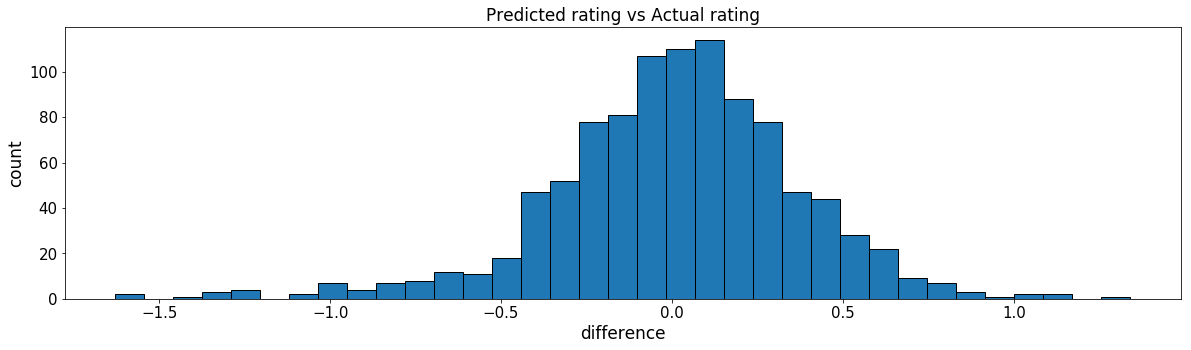

mean: 0.0082647726811
std: 0.364689021219


In [209]:
# difference of model from user rating
import matplotlib.pyplot as plt
_= plt.figure(figsize=(20,5))
_= plt.hist(difference, bins=35, edgecolor="k")
_= plt.xticks(size=15)
_= plt.yticks(size=15)
_= plt.xlabel('difference', size=17)
_= plt.ylabel('count', size=17)
_= plt.title('Predicted rating vs Actual rating', size=17)
plt.show()
mean_diff = np.mean(difference)
std_diff = np.std(difference)
print('mean:',mean_diff)
print('std:',std_diff)

In [ ]:


from sklearn.svm import LinearSVC
 
# initialise the SVM classifier
classifier = LinearSVC()
 
classifier.fit(X_train, y_train)


In [90]:
# Naive Bayes predictor

text_clf= Pipeline([('vect', CountVectorizer(min_df=7)),
                   ('tfidf', TfidfTransformer()),
                   ('clf',MultinomialNB()) ])

text_clf = text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

ValueError: Unknown label type: (array([ 3.78,  3.16,  4.27, ...,  4.1 ,  4.01,  3.81]),)

In [ ]:
# RANDOM FOREST 

X_train2 = X_train[:5000]
y_train2 = y_train[:5000]
X_test2 = X_test[10000:10500]
y_test2 = y_test[10000:10500]

from sklearn.ensemble import RandomForestClassifier as RFC
text_clf= Pipeline([('vect', CountVectorizer(min_df=5)),
                   ('tfidf', TfidfTransformer()),
                   ('forest',RFC(n_estimators=300)) ])
text_clf = text_clf.fit(X_train2, y_train2)
predicted = text_clf.predict(X_test2)
np.mean(predicted == y_test2)

In [78]:
# CALCULATE PREDICTION FOR ONE STYLE  -- doesn't work on my data
# from kaggle.com/adamschroeder/countvectorizer-tfidfvectorizer-predict-comments
# ValueError: Found input variables with inconsistent numbers of samples: [32802, 3857]
# when calling cross_val_score.  I reduced df length in "train_target = y_train[y_train==...]
from sklearn.feature_extraction.text import TfidfVectorizer
word_vect = TfidfVectorizer()
word_vect.fit(X_train)
X_train_word_features = word_vect.transform(X_train)
test_features = word_vect.transform(X_test)

style_names = ['American IPA','American Porter'] 
# ['American Pale Ale (APA)','Saison / Farmhouse Ale','American Double / Imperial IPA']
losses = []
auc = []
for style_name in style_names:
    #call the labels one at a time so we can run the classifier on them
    train_target = y_train[y_train==style_name]
    test_target = y_test[y_test==style_name]
    classifier = LogisticRegression(solver='sag', C=10)
    cv_loss = np.mean(cross_val_score(classifier, X_train_word_features, 
                                      train_target, cv=5, scoring='neg_log_loss'))
    losses.append(cv_loss)
    print('CV Log_loss score for class {} is {}'.format(style_name, cv_loss))
    cv_score = np.mean(cross_val_score(classifier, X_train_word_features, 
                                       train_target, cv=5, scoring='accuracy'))
    print('CV Accuracy score for class {} is {}'.format(style_name, cv_score))
    
    classifier.fit(X_train, train_target)
    y_pred = classifier.predict(test_features)
    y_pred_prob = classifier.predict_proba(test_features)[:, 1]
    auc_score = metrics.roc_auc_score(test_target, y_pred_prob)
    auc.append(auc_score)
    print("CV ROC_AUC score {}\n".format(auc_score))
    
    print(confusion_matrix(test_target, y_pred))
    print(classification_report(test_target, y_pred))

print('Total average CV Log_loss score is {}'.format(np.mean(losses)))
print('Total average CV ROC_AUC score is {}'.format(np.mean(auc)))    


NameError: name 'cross_val_score' is not defined

### start over here

In [60]:
df = df_copy

In [66]:
#prep the data
df = df_copy
df = df.drop(['name','brewery'], axis=1)
# drop all reviews with < 15 characters
df = df[df['review'].map(len) > 14]

In [68]:
print(len(df))

49291


In [69]:
t_id = 0
text = df.loc[t_id, 'review']

In [72]:
from gensim.summarization import summarize, keywords

word_scores = keywords(text, words=5, scores=True, split=True, lemmatize=True)

ModuleNotFoundError: No module named 'gensim'

In [111]:
#  Linear Regression predictor
# most of this module is from Ralph Bean, github
import sys
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.utils import sparsefuncs


n_samples = len(X_train)

vect = CountVectorizer(stop_words='english', ngram_range=(1,1))
data = vect.fit_transform(X_test)
print('* shape of the tfidf vectors', data.shape)
vectors = data

print('reduce the dimensionality of the data')
pca = TruncatedSVD(n_components=100)
data = pca.fit_transform(data)

print('* shape of the pca components', data.shape)
exp = np.var(data, axis=0)
full = sparsefuncs.mean_variance_axis(vectors,axis=0)[1].sum()
explained_variance_ratios = exp/full
confidence = sum(explained_variance_ratios)
print('confidence:',confidence)
    
print('training a support vector machine on first half')    
regr = LinearRegression()
regr.fit(data[:n_samples/2], data[y_train])

* shape of the tfidf vectors (14267, 42882)
reduce the dimensionality of the data
* shape of the pca components (14267, 100)
confidence: 0.676314427245
training a support vector machine on first half


IndexError: arrays used as indices must be of integer (or boolean) type